In [1]:
import gym_xarm, yaml, gym, pybulletgym
import datetime, os, pprint
import numpy as np
from test_env import naive_reach, naive_pac

import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from torch.distributions import Independent, Normal
from torch.optim.lr_scheduler import LambdaLR

from tianshou.env import DummyVectorEnv
from tianshou.utils.net.continuous import ActorProb, Critic
from tianshou.utils.net.common import Net
from tianshou.utils import TensorboardLogger
from tianshou.policy import PPOPolicy
from tianshou.trainer import onpolicy_trainer
from tianshou.data import Collector, ReplayBuffer, VectorReplayBuffer

# Note: do not remove __main__ as it will use multi-process
'''
load param
'''
with open("config/ppo_bullet.yaml", "r") as stream:
    try:
        config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

'''
make env
'''
env = gym.make(config['env'], config = config)
state_shape = env.observation_space.shape
action_shape = env.action_space.shape
max_action = env.action_space.high[0]
env.close()
test_envs = DummyVectorEnv(
    [lambda: gym.make(config['env'], config=config)],
    norm_obs = True,
    update_obs_rms = False
)
np.random.seed(config['seed'])
torch.manual_seed(config['seed'])
test_envs.seed(config['seed'])

'''
build and init network
'''
# if not (torch.cuda.is_available()):
config['device'] = 'cpu'
net_a = Net(
    state_shape,
    hidden_sizes=config['hidden_sizes'],
    activation=nn.Tanh,
    device=config['device']
)
actor = ActorProb(
    net_a,
    action_shape,
    max_action = max_action,
    unbounded=True,
    device=config['device']
).to(config['device'])
net_c = Net(
    state_shape,
    hidden_sizes=config['hidden_sizes'],
    activation=nn.Tanh,
    device=config['device']
)
critic = Critic(net_c, device=config['device']).to(config['device'])
# init parameters
torch.nn.init.constant_(actor.sigma_param, -0.5)
for m in list(actor.modules()) + list(critic.modules()):
    if isinstance(m, torch.nn.Linear):
        # orthogonal initialization
        torch.nn.init.orthogonal_(m.weight, gain=np.sqrt(2))
        torch.nn.init.zeros_(m.bias)
for m in actor.mu.modules():
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.zeros_(m.bias)
        m.weight.data.copy_(0.01 * m.weight.data)
# optimizer
optim = torch.optim.Adam(
    list(actor.parameters()) + list(critic.parameters()), lr=config['lr']
)
lr_scheduler = None
if config['lr_decay']:
    # decay learning rate to 0 linearly
    max_update_num = np.ceil(
        config['step_per_epoch'] / config['step_per_collect']
    ) * config['epoch']
    # [Q]
    lr_scheduler = LambdaLR(
        optim, lr_lambda=lambda epoch: 1 - epoch / max_update_num
    )

'''
set up policy
'''
# distribution function to get action
def dist(*logits):
    return Independent(Normal(*logits), 1)
policy = PPOPolicy(
    actor,
    critic,
    optim,
    dist,
    discount_factor=config['gamma'],
    gae_lambda=config['gae_lambda'],
    max_grad_norm=config['max_grad_norm'],
    vf_coef=config['vf_coef'],
    ent_coef=config['ent_coef'],
    reward_normalization=config['rew_norm'],
    action_scaling=True,
    action_bound_method=config['bound_action_method'],
    lr_scheduler=lr_scheduler,
    action_space=env.action_space,
    eps_clip=config['eps_clip'],
    value_clip=config['value_clip'],
    dual_clip=config['dual_clip'],
    advantage_normalization=config['norm_adv'],
    recompute_advantage=config['recompute_adv']
)
# load previous policy
policy.load_state_dict(torch.load('/home/pcy/Bimanual/tianshou-bullet/log/NaivePickAndPlace-v0/ppo/seed_0_1026_205023_NaivePickAndPlace-v0_ppo/policy.pth', map_location=config['device']))

'''
set up collector
'''
test_collector = Collector(policy, test_envs)

Error: Cannot re-register id: NaiveReach-v0

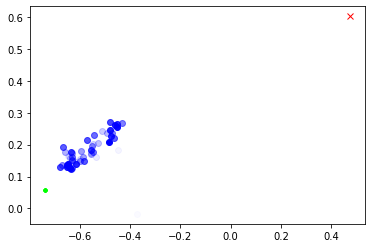

Final reward: 0.0, length: 50.0


<Figure size 432x288 with 0 Axes>

In [17]:
'''
render
'''
policy.eval()

test_collector.reset()
result = test_collector.collect(n_episode=1, render=0.00001)
print(f'Final reward: {result["rews"].mean()}, length: {result["lens"].mean()}')